In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

In [2]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()


Fraction inspired oxygen_mean  Fraction inspired oxygen_min  \
0                       0.484615                           0.4   
1                       0.600000                           0.5   
2                       0.481250                           0.4   
3                       0.400000                           0.4   
4                       0.566667                           0.4   

   Fraction inspired oxygen_max  Glucose_mean  Glucose_min  Glucose_max  \
0                           0.6    155.181818         52.0        280.0   
1                           1.0    127.954545         85.0        177.0   
2                           0.8    145.625000        116.0        180.0   
3                           0.4    100.142857         77.0        154.0   
4                           1.0    138.000000        116.0        155.0   

   Heart Rate_mean  Heart Rate_min  Heart Rate_max  Mean blood pressure_mean  \
0        52.367347            35.0            93.0                 87.096154   
1        72.660377            58.0           105.0                 72.315789   
2       107.260000            96.0           118.0                 86.462963   
3        57.250000            47.0            65.0                 69.762712   
4        84.015625            64.0           114.0                 70.662162   

   ...  Temperature_mean  Temperature_min  Temperature_max  Weight_mean  \
0  ...         36.356349        35.200000        37.100000    81.419764   
1  ...         36.786325        36.388889        37.055556    93.103510   
2  ...         37.316239        36.611111        37.944444    67.500000   
3  ...               NaN              NaN              NaN    80.403091   
4  ...         36.148990        34.722222        37.666667          NaN   

   Weight_min  Weight_max   pH_mean  pH_min  pH_max  mortality  
0   81.419764   81.419764  7.328750    7.19    7.40        1.0  
1   91.807021   95.000000  7.377143    7.34    7.42        0.0  
2   67.500000   67.500000  7.372000    7.29    7.45        0.0  
3   76.838485   86.000000  7.161250    6.00    7.36        1.0  
4         NaN         NaN  7.374444    7.27    7.42        1.0  

[5 rows x 34 columns]

In [3]:
import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split


# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=3)
df_imputed = knn_imputer.fit_transform(df)


# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)


# Features & Target
x = df_imputed[[
    'Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min', 'Fraction inspired oxygen_max', \
    'Glucose_mean', 'Glucose_min', 'Glucose_max', \
    'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',\
    'Mean blood pressure_mean', 'Mean blood pressure_min', 'Mean blood pressure_max', \
    'Diastolic blood pressure_mean', 'Diastolic blood pressure_min', 'Diastolic blood pressure_max',\
    'Systolic blood pressure_mean', 'Systolic blood pressure_min', 'Systolic blood pressure_max',\
    'Oxygen saturation_mean', 'Oxygen saturation_min', 'Oxygen saturation_max',\
    'Respiratory rate_mean', 'Respiratory rate_min', 'Respiratory rate_max',\
    'Temperature_mean', 'Temperature_min', 'Temperature_max',\
    'Weight_mean', 'Weight_min', 'Weight_max',\
    'pH_mean', 'pH_min', 'pH_max']]
y = df_imputed['mortality']


# Applying SMOTE
smote = SMOTE(random_state = 42)
x_resampled, y_resampled = smote.fit_resample(x, y)


print('Original Dataset Shape:', y.value_counts())
print('\nResampled Dataset Shape:', y_resampled.value_counts())


print ('\n-------------------------------------------------------------------')
# Function to Detect Outliers using IQR
def detect_outlier_iqr(data):
  outliers = {}
  for column in df.columns:
      Q1 = data[column].quantile(0.25)
      Q3 = data[column].quantile(0.75)
      IRQ = Q3 - Q1
      lower_bound = Q1 - 1.5*IRQ
      upper_bound = Q3 + 1.5*IRQ
      outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
  return outliers

# Combine feataures and target variable for outlier detection
resampled_data = pd.DataFrame(x_resampled, columns=x.columns)
resampled_data['mortality'] = y_resampled

# Checking for Outliers in the Resampled Data
outliers_in_resampled = detect_outlier_iqr(pd.DataFrame(resampled_data))
for feature, outliers in outliers_in_resampled.items():
    print(f"Outliers detected in'{feature}':")
    print(outliers)
    print('\n~~~~~~~~~~~~~~~~~~~~~')



Original Dataset Shape: 0.0    4232
1.0    1415
Name: mortality, dtype: int64

Resampled Dataset Shape: 1.0    4232
0.0    4232
Name: mortality, dtype: int64

-------------------------------------------------------------------
Outliers detected in'Fraction inspired oxygen_mean':
      Fraction inspired oxygen_mean  Fraction inspired oxygen_min  \
60                         1.000000                      1.000000   
65                         1.000000                      1.000000   
98                         1.000000                      1.000000   
118                        0.862500                      0.700000   
158                        0.833333                      0.500000   
...                             ...                           ...   
8279                       0.875009                      0.500075   
8308                       0.830007                      0.807035   
8338                       0.815078                      0.500000   
8429                       0.9

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [5]:
y_test

2240    1.0
443     0.0
2752    0.0
5541    0.0
2760    0.0
       ... 
64      0.0
3656    0.0
888     0.0
3312    0.0
5464    0.0
Name: mortality, Length: 1695, dtype: float64

In [5]:
import lightgbm as lgb
print(lgb.__version__)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

weights=np.ones(X_train.shape[0])
lgb_train = lgb.Dataset(X_train, y_train, weight=weights, free_raw_data=False)



4.5.0


In [67]:

from sklearn.metrics import mean_squared_error

mse_all=list()


def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])
    return result


def custom_loss(y_true,y_pred):
    t=y_true
    y = sigmoid(y_pred)
    grad = y - t
    hess = y * (1 - y)

    mse_all.append(mean_squared_error(t,y))

    return grad, hess

"""
# Custom evaluation metric
def custom_eval_metric2(y_true,y_pred):
    # Convert predictions to probabilities
    y_pred = 1 / (1 + np.exp(-y_pred))
    return 'custom_logloss', log_loss(y_true, y_pred), False
"""

"\n# Custom evaluation metric\ndef custom_eval_metric2(y_true,y_pred):\n    # Convert predictions to probabilities\n    y_pred = 1 / (1 + np.exp(-y_pred))\n    return 'custom_logloss', log_loss(y_true, y_pred), False\n"

In [68]:

import lightgbm as lgb

#by chatgpt
class CustomLGBMClassifier(lgb.LGBMClassifier):
    def predict(self, X, raw_score=False):
        # Call the original predict method to get probabilities
        probs = sigmoid(super().predict(X,raw_score=True)) # Get probabilities for the positive class
        
        # If raw_scores is True, return the raw scores (logits)
        if raw_score:
            # Calculate raw scores using the inverse of the sigmoid function
            return sigmoid(np.log(probs / (1 - probs)))  # Logit transformation
        
        # Convert probabilities to class labels (0 or 1)
        return np.where(probs >= 0.5, 1, 0)


clf = CustomLGBMClassifier(
    objective=custom_loss,
    metric='None',
    random_seed= 0, 
    max_depth=50,
    reg_alpha=0.3,
    reg_lambda=0.2,
    force_col_wise=True,
    is_unbalance=True,
    boosting_type='gbdt')



In [69]:
# https://www.geeksforgeeks.org/cross-validation-and-hyperparameter-tuning-of-lightgbm-model/

# parameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth':[20,30,40],
    'reg_alpha':[0.1,0.2,0.3],
    'reg_lambda':[0.1,0.2,0.3]
}

best_hyperparameters = {}
best_values = {}


# Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           scoring='accuracy',cv=5)
 
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X_train, y_train)
 
# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())



# Train a LightGBM model with the best hyperparameters
#clf = CustomLGBMClassifier(**best_params)
#clf.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5185
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1073741824) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5197
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_l

In [70]:
best_params

{'learning_rate': 0.1,
 'max_depth': 30,
 'n_estimators': 100,
 'num_leaves': 20,
 'reg_alpha': 0.2,
 'reg_lambda': 0.2}

In [71]:
#https://www.geeksforgeeks.org/understanding-python-pickling-example/
import pickle

# Parameters to save
params = best_params

# Save to a pickle file
with open('model_params.pkl', 'wb') as file:
    pickle.dump(params, file)


In [73]:

# Load parameters from the pickle file
with open('model_params.pkl', 'rb') as file:
    best_params = pickle.load(file)


In [76]:
# build the lightgbm model
from scipy import special
from sklearn.metrics import accuracy_score


# Initialize the model
#clf = lgb.LGBMClassifier(objective=custom_loss2, eval_metric='logloss')

#call back function
#https://github.com/microsoft/LightGBM/issues/5541
""""
my_predictions = []

def save_predictions(predictions):
    def callback(env):
            train_preds = env.model._Booster__inner_predict(0).copy()
            predictions.append(train_preds)
    return callback
"""

clf = CustomLGBMClassifier(
    objective=custom_loss,
    metric='None',
    random_seed= 0, 
    force_col_wise=True,
    is_unbalance=True,
    boosting_type='gbdt',
    **best_params
  )

mse_all=[]
clf.fit(X_train, y_train)


y_pred=clf.predict(X_train)
y_val=clf.predict(X_test)
y_val_prob=clf.predict(X_test,raw_score=True)

best_dec_pred=0.5

print(f'\nLightGBM Model training accuracy, {accuracy_score(y_train, y_pred)}')

print(f'\nLightGBM Model testing accuracy, {accuracy_score(y_test, y_val)}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1073741824) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function

LightGBM Model training accuracy, 0.916751012145749

LightGBM Model testing accuracy, 0.759882005899705


In [22]:
model = clf.booster_

filew= open("testmodel_params.txt","w")
filew.write(str(model.params))
filew.close()

In [39]:
model.trees_to_dataframe()

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S2        0-S1         None   
1              0           2       0-S2      0-S20        0-S4         0-S0   
2              0           3      0-S20       0-L0       0-L21         0-S2   
3              0           4       0-L0       None        None        0-S20   
4              0           4      0-L21       None        None        0-S20   
...          ...         ...        ...        ...         ...          ...   
3045          49           5      49-L6       None        None        49-S6   
3046          49           5      49-L7       None        None        49-S6   
3047          49           3      49-S4      49-L4       49-L5        49-S3   
3048          49           4      49-L4       None        None        49-S4   
3049          49           4      49-L5       None        None        49-S4   

              split_feature  split_gain   threshold decision_type  \
0     Respiratory_rate_mean   66.369400   20.841531            <=   
1          Temperature_mean   36.837399   35.984630            <=   
2           Temperature_min    8.692320   35.250000            <=   
3                      None         NaN         NaN          None   
4                      None         NaN         NaN          None   
...                     ...         ...         ...           ...   
3045                   None         NaN         NaN          None   
3046                   None         NaN         NaN          None   
3047            Glucose_min    2.031740  106.500000            <=   
3048                   None         NaN         NaN          None   
3049                   None         NaN         NaN          None   

     missing_direction missing_type     value      weight  count  
0                 left         None  0.000000    0.000000   3952  
1                 left         None -0.121031  626.250000   2505  
2                 left         None  0.017344   18.250000     73  
3                 None         None  0.060967   13.250000     53  
4                 None         None -0.090385    5.000000     20  
...                ...          ...       ...         ...    ...  
3045              None         None  0.092907    4.499647     23  
3046              None         None -0.000700    3.662174     24  
3047              left         None -0.040717   11.330000     75  
3048              None         None  0.015316    3.506751     22  
3049              None         None -0.069328    7.823275     53  

[3050 rows x 15 columns]

In [41]:
#model = lgb.Booster(model_file='lightgbm_model.txt')
model.save_model("lightgbm_model.txt")

Confusion matrix

 [[1191   64]
 [ 343   97]]

True Positives(TP) =  1191

True Negatives(TN) =  97

False Positives(FP) =  64

False Negatives(FN) =  343
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85      1255
         1.0       0.60      0.22      0.32       440

    accuracy                           0.76      1695
   macro avg       0.69      0.58      0.59      1695
weighted avg       0.73      0.76      0.72      1695



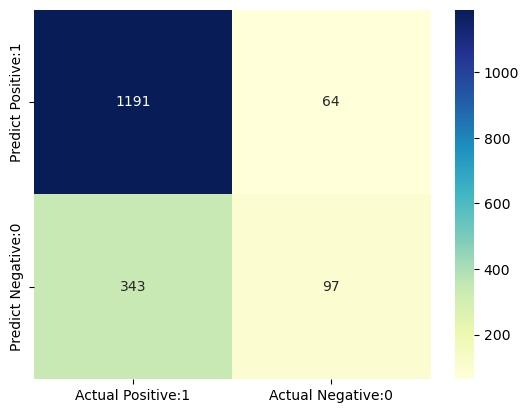

In [23]:

from sklearn.metrics import confusion_matrix
#print(y_test)
#print(y_val)
cm = confusion_matrix(y_test, y_val)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])



# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')



from sklearn.metrics import classification_report
print(classification_report(y_test, y_val))


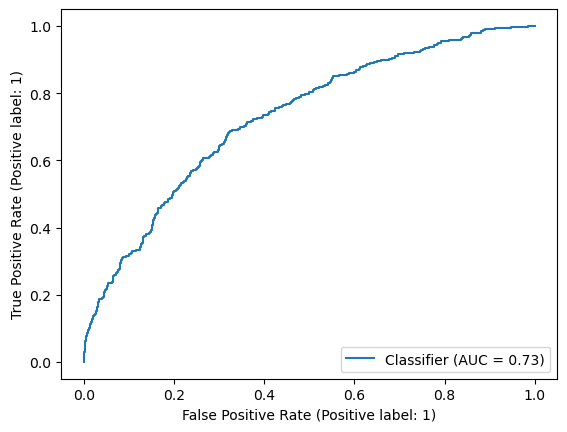

In [43]:
#https://towardsdatascience.com/understanding-the-roc-curve-in-three-visual-steps-795b1399481c
#https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.RocCurveDisplay.html


import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y_test, y_val_prob)

plt.show()

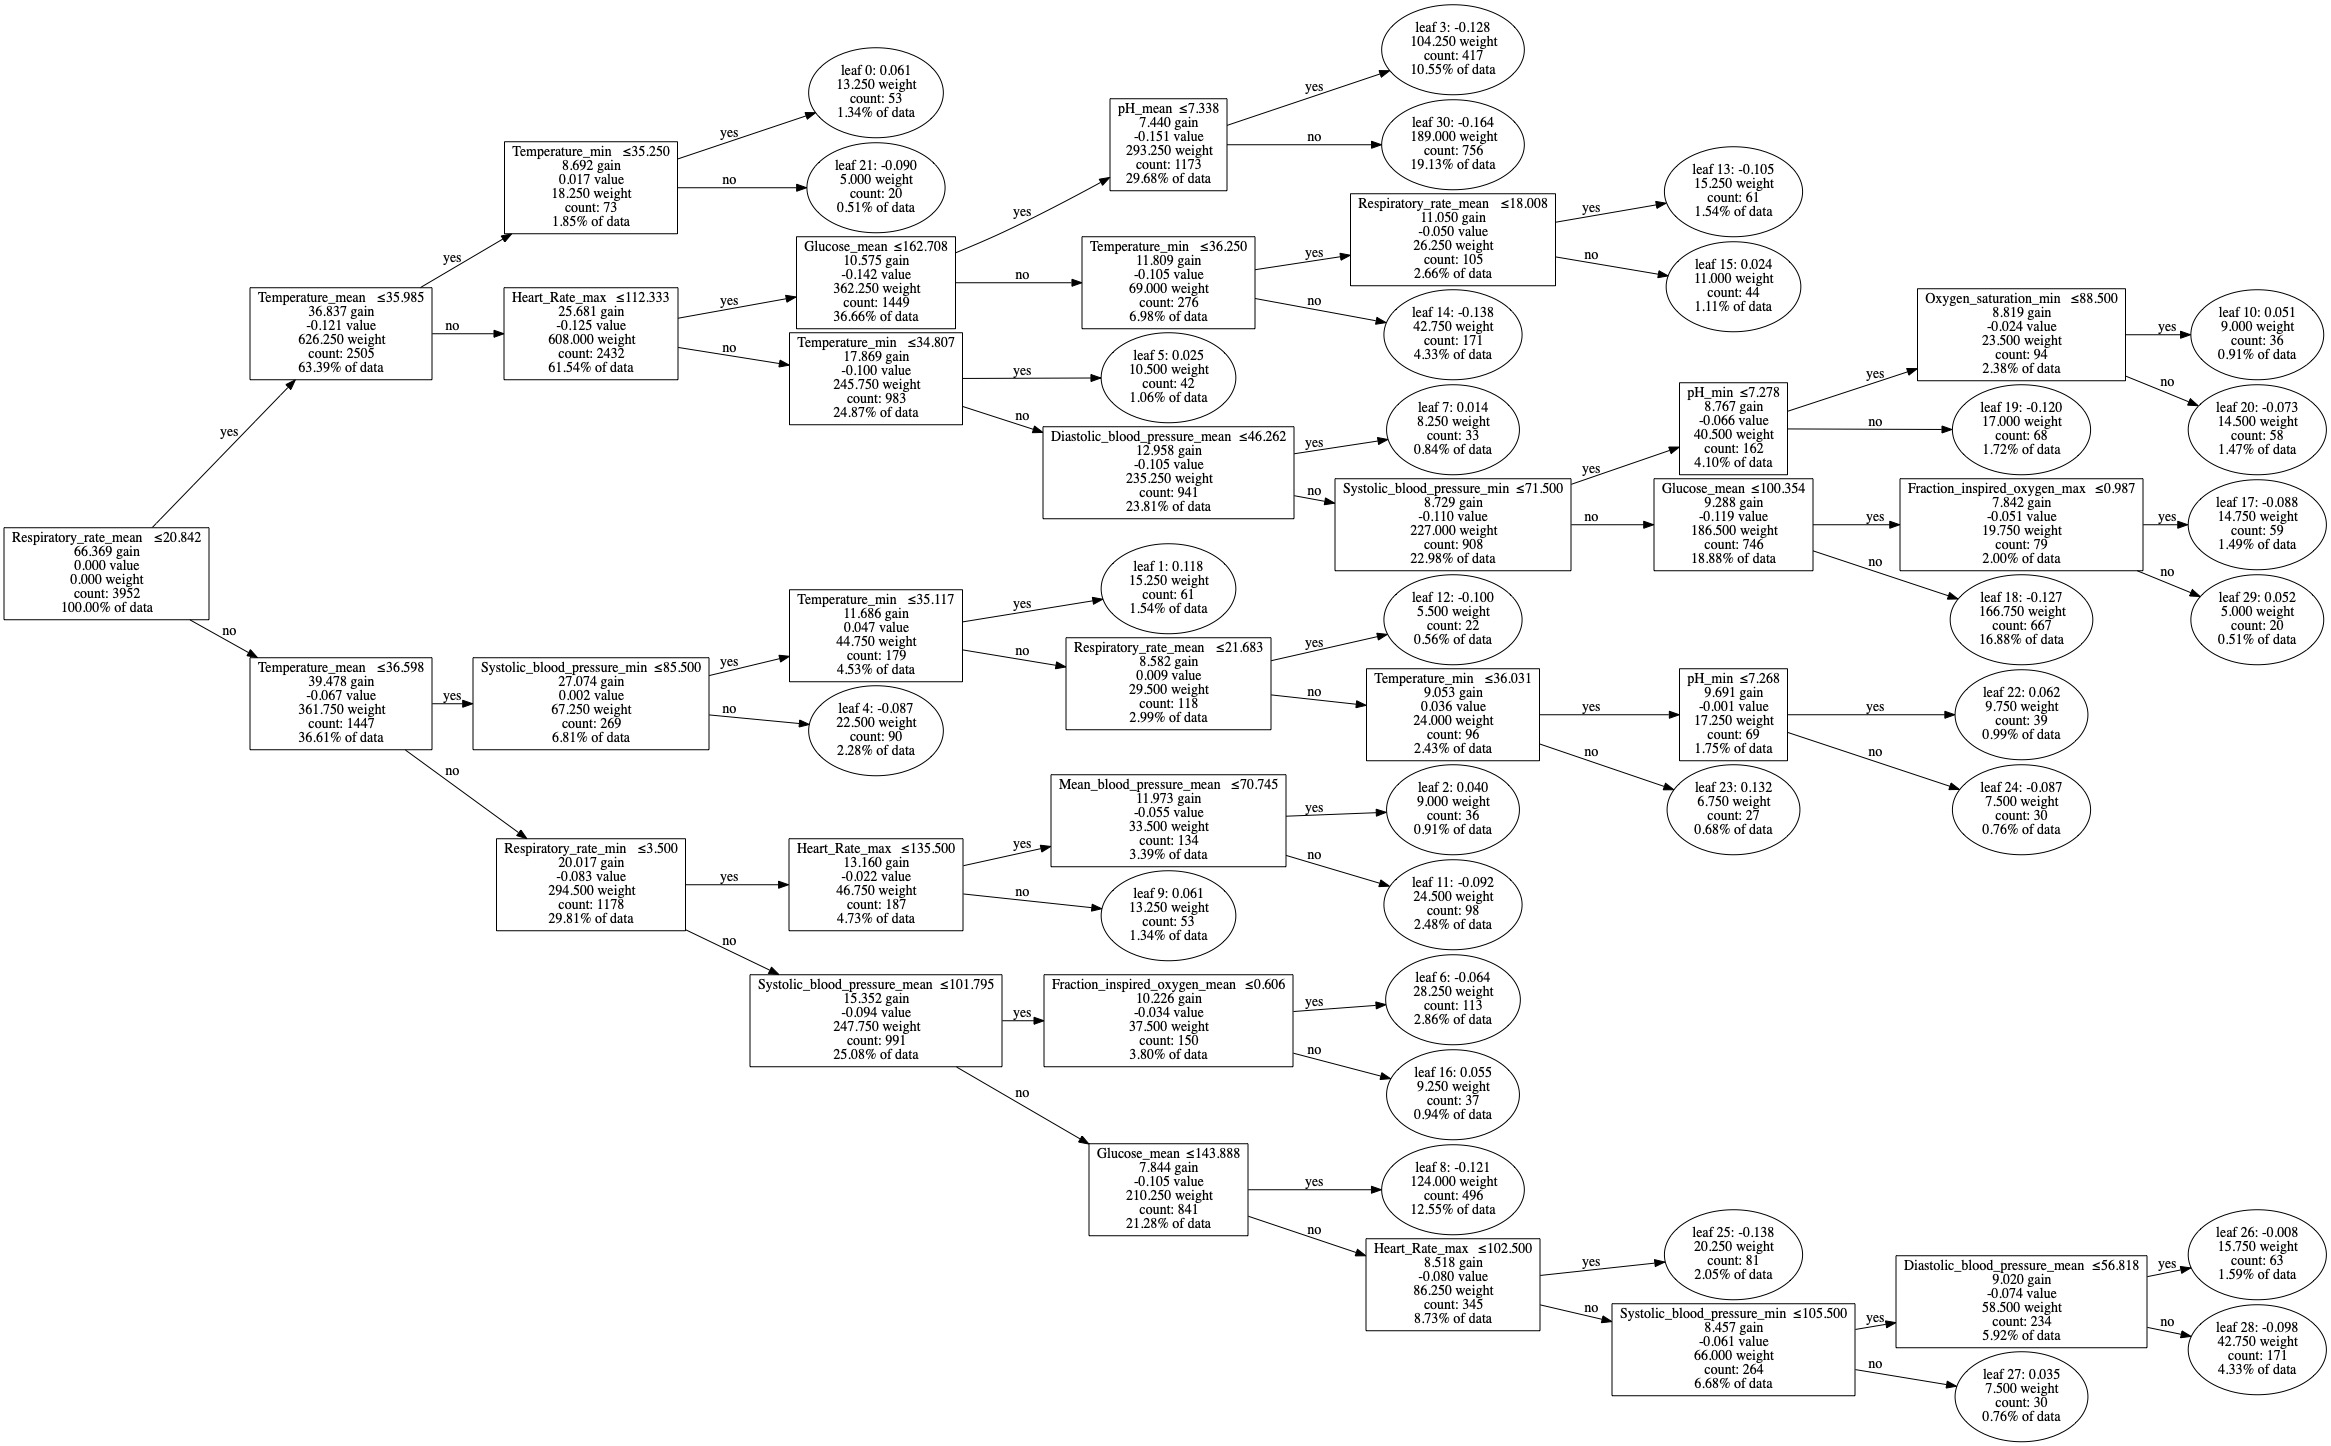

In [44]:

from graphviz import Source
from PIL import Image

graph = lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count','internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

image=graph.render('lightgbm_plot_tree', format='jpg')

#image = Image.open("example.jpg")
#image.save("lightgbm_plot_tree.jpg")
#https://stackoverflow.com/questions/66475025/how-to-calculate-the-weight-and-value-in-lightgbm

image = Image.open("lightgbm_plot_tree.jpg")
image


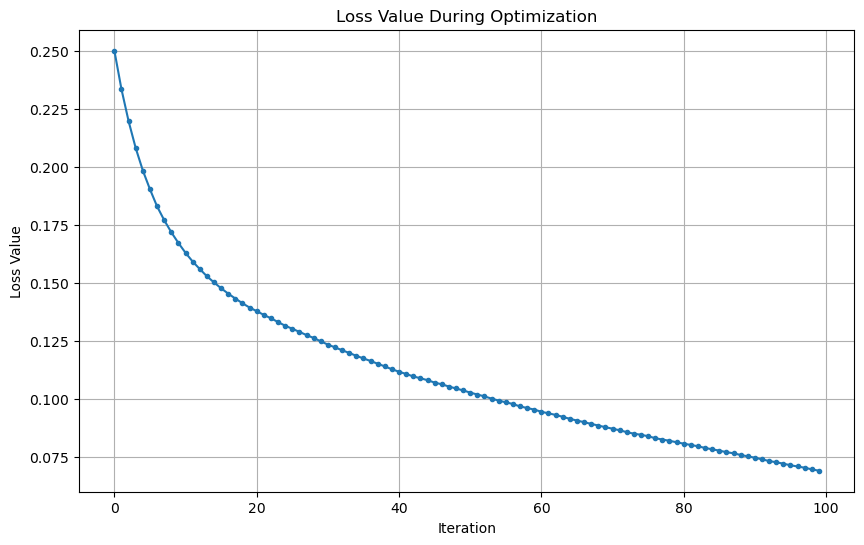

In [77]:


# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(mse_all, marker='.', linestyle='-')
plt.title('Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

In [46]:
#https://www.kaggle.com/code/adrianlievano/light-gbm-with-stratified-kfold

from sklearn.model_selection import  StratifiedKFold

from sklearn.metrics import mean_squared_error


skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

skf.get_n_splits(X_train, y_train)

print(x.shape)
print(y.shape)

mse_all=list()
all_mse_val=list()

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    #print(train_index, test_index)
    #print(train_index.shape, test_index.shape)
    X_train, X_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]


        
    clf = CustomLGBMClassifier(
        objective=custom_loss,
        metric='None',
        random_seed= 0, 
        max_depth=50,
        reg_alpha=0.3,
        reg_lambda=0.2,
        force_col_wise=True,
        is_unbalance=True,
        boosting_type='gbdt',
        **best_params
      )


    clf.fit(X_train, y_train)

    y_pred=clf.predict(X_test)



    all_mse_val.append(mean_squared_error(y_test, y_pred))


#print(len(all_mse_val))


(5647, 33)
(5647,)
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=50) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1125899906842624) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5241
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=50) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1125899906842624) in params. Alternatively, pass (

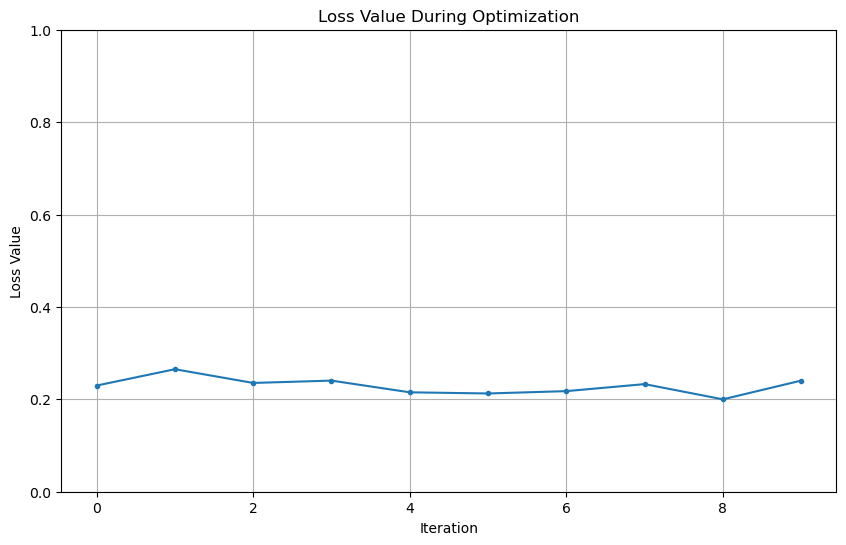

In [48]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(all_mse_val, marker='.', linestyle='-')
plt.title('Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.ylim(0,1)
plt.grid()
plt.show()

(array([ 12.,  38.,  81., 137., 192., 237., 313., 413., 388., 439., 383.,
        411., 327., 276., 280., 201., 165., 152., 149., 123., 132., 129.,
        108.,  83.,  80.,  86.,  73.,  53.,  45.,  42.,  27.,  18.,  15.,
         12.,  14.,   2.,   7.,   3.,   0.,   1.]),
 array([-3.37575101, -3.21761188, -3.05947276, -2.90133363, -2.7431945 ,
        -2.58505537, -2.42691625, -2.26877712, -2.11063799, -1.95249886,
        -1.79435974, -1.63622061, -1.47808148, -1.31994236, -1.16180323,
        -1.0036641 , -0.84552497, -0.68738585, -0.52924672, -0.37110759,
        -0.21296847, -0.05482934,  0.10330979,  0.26144892,  0.41958804,
         0.57772717,  0.7358663 ,  0.89400542,  1.05214455,  1.21028368,
         1.36842281,  1.52656193,  1.68470106,  1.84284019,  2.00097932,
         2.15911844,  2.31725757,  2.4753967 ,  2.63353582,  2.79167495,
         2.94981408]),
 <BarContainer object of 40 artists>)

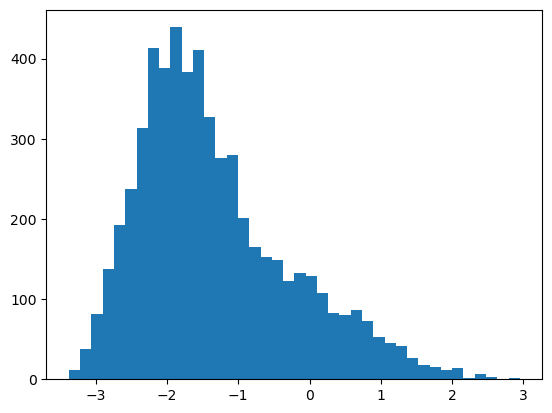

In [47]:
plt.hist(model.predict(x),bins=40)